In [0]:
!pip install pytorch-transformers
!pip install emoji
!pip install pyenchant
!pip install nltk
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from pytorch_transformers import XLNetModel, XLNetTokenizer, XLNetForSequenceClassification
from pytorch_transformers import BertModel, BertTokenizer, BertForSequenceClassification
from pytorch_transformers import AdamW
from tqdm import tqdm, trange
import pandas as pd
import io
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files
from torch import Tensor
from torch.nn import BCEWithLogitsLoss
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torch.autograd import Variable
import torch.nn.functional as F
from sklearn.metrics import f1_score, recall_score, precision_score, multilabel_confusion_matrix
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
torch.cuda.get_device_name(0)

     |████████████████████████████████| 184kB 2.8MB/s 
     |████████████████████████████████| 870kB 47.6MB/s 
     |████████████████████████████████| 1.0MB 37.8MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.38-cp36-none-any.whl size=884628 sha256=3d027ea8a1ade82d5edca8d43f286b191076a0f811fcaac5249f8a4c20125fbe
  Stored in directory: /root/.cache/pip/wheels/6d/ec/1a/21b8912e35e02741306f35f66c785f3afe94de754a0eaf1422
Successfully built sacremoses
     |████████████████████████████████| 51kB 1.7MB/s 
  Created wheel for emoji: filename=emoji-0.5.4-cp36-none-any.whl size=42176 sha256=d7d5dee220ac3e1d03e7f9558f5d7269b7846a430b085582b657d26de779e720
  Stored in directory: /root/.cache/pip/wheels/2a/a9/0a/4f8e8cce8074232aba240caca3fade315bb49fac68808d1a9c
Successfully built emoji
     |████████████████████████████████| 61kB 2.0MB/s 


Using TensorFlow backend.


'Tesla P100-PCIE-16GB'

In [0]:
# Upload train.tsv and validation.tsv
from google.colab import files
uploaded = files.upload()


Saving dev.tsv to dev.tsv
Saving test.tsv to test.tsv
Saving train.tsv to train.tsv
Saving validation.tsv to validation.tsv


In [0]:
# Represent labels as one-hot encoded vectors
train_df = pd.read_csv("train.tsv", delimiter='\t')
test_df = pd.read_csv("validation.tsv", delimiter='\t')
train_tweets = train_df.tweet.values
test_tweets = test_df.tweet.values
label_names=["anger","disgust","fear","joy","sadness","surprise"]
label_ids=[1,2,3,4,5,6]
train_labels=[]
for i in range(len(train_df)):
    train_label=[]
    for key in label_names:
        train_label.append(int(train_df.iloc[i][key]))
    train_labels.append(train_label)
test_labels=[]
for i in range(len(test_df)):
    test_label=[]
    for key in label_names:
        test_label.append(int(test_df.iloc[i][key]))
    test_labels.append(test_label)

In [0]:
# Pre-processing
import regex as re
import emoji
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize
import nltk
from collections import Counter
from itertools import chain 
nltk.download('stopwords')
nltk.download('punkt')
ps = PorterStemmer()
def preprocess(tweets, negation_handling = True, links_handling = True, stopword=True):
  max = 0
  clean_tweets = []
  # NLTK stop words
  stop_words = set(stopwords.words('english')) 
  for tweet in tweets:
    if links_handling:
      # Delete links and mentions
      tweet = re.sub(r"(?:\@|https?\://)\S+", "", tweet)
    neg_feature = re.compile(r"^not$|never|[a-z]n't$")   # regular expression for not, n't and never
    negation = False
    # Tweet to list of words
    words=word_tokenize(tweet)
    if stopword:
    # Delete the stopwords
      words = [w for w in words if not w in stop_words]
    for i in range(len(words)): 
      if negation_handling:
        #Add NOT_ to every word after not, n't and never until punctuation
        if (words[i] not in (',', '.', '?', '!', ';')) & negation:
            words[i] = "NOT_" + words[i]
        if neg_feature.search(words[i]):
            negation = True
        if words[i] in (',', '.', '?', '!', ';'):
            negation = False
    tweet = ' '.join(word for word in words)
    clean_tweets.append(tweet)
  #Add begining and end of sentence tokens
  clean_tweets = [tweet + " [SEP] [CLS]" for tweet in clean_tweets]
  return clean_tweets
def t_count(t, val):
    elements_equal_to_value = tf.equal(t, val)
    as_ints = tf.cast(elements_equal_to_value, tf.int32)
    count = tf.reduce_sum(as_ints)
    return count
def to_labels(t):
  print(len(t))
  print(Counter(list(chain.from_iterable([[label_names[j] for j in range(len(i.tolist())) if i.tolist()[j]==1] for i in t]))))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [0]:
class XLNetForMultiLabelSequenceClassification(XLNetForSequenceClassification):
    r"""
        Method overriding of XLNetForSequenceClassification to adapt it to multi-label classification 
        Changes: labels vector is extended to the number labels instead of 1
    """

    def forward(self, input_ids, token_type_ids=None, input_mask=None, attention_mask=None,
                mems=None, perm_mask=None, target_mapping=None,
                labels=None, head_mask=None):
        transformer_outputs = self.transformer(input_ids, token_type_ids=token_type_ids,
                                               input_mask=input_mask, attention_mask=attention_mask,
                                               mems=mems, perm_mask=perm_mask, target_mapping=target_mapping,
                                               head_mask=head_mask)
        output = transformer_outputs[0]

        output = self.sequence_summary(output)
        logits = self.logits_proj(output)

        # Keep mems, hidden states, attentions if there are in it
        outputs = (logits,) + transformer_outputs[1:]

        if labels is not None:
            loss_fct = BCEWithLogitsLoss()
        #Changes: labels vector is extended to the number labels instead of 1
            loss = loss_fct(logits.view(-1, self.num_labels),
                            labels.view(-1, self.num_labels).type_as(logits.view(-1, self.num_labels)))
            outputs = (loss,) + outputs

        return outputs  # (loss), logits, (hidden_states), (attentions)

In [0]:
class BertForMultiLabelSequenceClassification(BertForSequenceClassification):
    r"""
        Method overriding of BertForSequenceClassification to adapt it to multi-label classification 
        Changes: labels vector is extended to the number labels instead of 1
    """

    def forward(self, input_ids=None, attention_mask=None, token_type_ids=None,
                position_ids=None, head_mask=None, inputs_embeds=None, labels=None):
        outputs = self.bert(input_ids,
                            attention_mask=attention_mask,
                            token_type_ids=token_type_ids,
                            position_ids=position_ids,
                            head_mask=head_mask)
        pooled_output = outputs[1]

        pooled_output = self.dropout(pooled_output)
        logits = self.classifier(pooled_output)

        outputs = (logits,) + outputs[2:]  # add hidden states and attention if they are here

        if labels is not None:
            loss_fct = BCEWithLogitsLoss()
        #Changes: labels vector is extended to the number labels instead of 1
            loss = loss_fct(logits.view(-1, self.num_labels),
                            labels.view(-1, self.num_labels).type_as(logits.view(-1, self.num_labels)))
            outputs = (loss,) + outputs

        return outputs  # (loss), logits, (hidden_states), (attentions)

In [0]:
def xlnet_model(train_tweets, test_tweets, train_labels, test_labels, epochs = 4, batch_size = 32, lr = 3e-5, T=0.5):
    """
    lr = learning rate
    T = probabilistic threshold
    """
    tokenizer = XLNetTokenizer.from_pretrained('xlnet-base-cased', do_lower_case=True)
    MAX_LEN = 128

    tokenized_train = [tokenizer.tokenize(sent) for sent in train_tweets]
    train_inputs = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_train]
    train_inputs = pad_sequences(train_inputs, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")
    # Create attention masks
    train_masks = []
    # Create a mask of 1s for each token followed by 0s for padding
    for seq in train_inputs:
      seq_mask = [float(i>0) for i in seq]
      train_masks.append(seq_mask)

    tokenized_test = [tokenizer.tokenize(sent) for sent in test_tweets]
    test_inputs = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_test]
    test_inputs = pad_sequences(test_inputs, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")
    # Create attention masks
    test_masks = []
    # Create a mask of 1s for each token followed by 0s for padding
    for seq in test_inputs:
      seq_mask = [float(i>0) for i in seq]
      test_masks.append(seq_mask)

    train_inputs = torch.tensor(train_inputs)
    test_inputs = torch.tensor(test_inputs)
    train_labels = torch.tensor(train_labels)
    test_labels = torch.tensor(test_labels)
    train_masks = torch.tensor(train_masks)
    test_masks = torch.tensor(test_masks)

    # Create an iterator of our data with torch DataLoader. This helps save on memory during training because, unlike a for loop, 
    # with an iterator the entire dataset does not need to be loaded into memory

    train_data = TensorDataset(train_inputs, train_masks, train_labels)
    train_sampler = RandomSampler(train_data)
    train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

    test_data = TensorDataset(test_inputs, test_masks, test_labels)
    test_sampler = SequentialSampler(test_data)
    test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)
    # Load XLNEtForSequenceClassification, the pretrained XLNet model with a single linear classification layer on top. 

    model = XLNetForMultiLabelSequenceClassification.from_pretrained("xlnet-base-cased", num_labels=6)
    model.cuda()
    param_optimizer = list(model.named_parameters())
    no_decay = ['bias', 'gamma', 'beta'] 
    optimizer_grouped_parameters = [
        {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
        'weight_decay_rate': 0.01},
        {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
        'weight_decay_rate': 0.0}
    ]
    # This variable contains all of the hyperparemeter information that the training loop needs
    optimizer = AdamW(optimizer_grouped_parameters,
                        lr=lr)
    # Store the loss
    train_loss_set = []
    batch_size_ = 0
    model_metrics_ = []
    # trange is a tqdm wrapper around the normal python range
    for _ in trange(epochs, desc="Epoch"):
      
      # Tracking variables
      tr_loss = 0
      nb_tr_examples, nb_tr_steps = 0, 0
      
      # Train the data for one epoch
      for step, batch in enumerate(train_dataloader):
        # Add batch to GPU
        # Training
        # Set our model to training mode (as opposed to evaluation mode)
        model.train()
        batch = tuple(t.to(device) for t in batch)
        # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask, b_labels = batch
        # Clear out the gradients (by default they accumulate)
        optimizer.zero_grad()
        # Forward pass
        outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
        loss = outputs[0]
        logits = outputs[1]
        train_loss_set.append(loss.item())    
        # Backward pass
        loss.backward()
        # Update parameters and take a step using the computed gradient

        optimizer.step()
        to_labels(b_labels)
        
        # Update tracking variables
        tr_loss += loss.item()
        nb_tr_examples += b_input_ids.size(0)
        nb_tr_steps += 1
        # test
        # Put model in evaluation mode to evaluate loss on the test set
        model.eval()

        # Tracking variables 
        eval_loss=0
        nb_eval_steps, nb_eval_examples = 0, 0
        labels,predictions=[],[]
        # Evaluate data for one epoch
        for batch_t in test_dataloader:
          # Add batch to GPU
          batch_t = tuple(t.to(device) for t in batch_t)
          # Unpack the inputs from our dataloader
          t_b_input_ids, t_b_input_mask, t_b_labels = batch_t
          # Telling the model not to compute or store gradients, saving memory and speeding up test
          with torch.no_grad():
            # Forward pass, calculate logit predictions
            output = model(t_b_input_ids, token_type_ids=None, attention_mask=t_b_input_mask)
            logits = output[0]
          
          # Move logits and labels to CPU

          prob=torch.sigmoid(logits)
          # If probability greater than or equal to threshold T the tweet contains that emotion
          pred = (prob >= T).type(torch.FloatTensor)
          pred = pred.detach().cpu().numpy().astype(int).tolist()
          label_ids = t_b_labels.to('cpu').numpy().tolist()
          labels+=label_ids
          predictions+=pred
        labels=np.array(labels)
        predictions=np.array(predictions)
        recall_micro=recall_score(labels, predictions, average = "micro")
        recall_macro=recall_score(labels, predictions, average = "macro")
        precision_micro=precision_score(labels, predictions, average = "micro")
        precision_macro=precision_score(labels, predictions, average = "macro")
        f1_micro=f1_score(labels, predictions, average = "micro")
        f1_macro=f1_score(labels, predictions, average = "macro")
        model_metrics={("Precision","Micro"):precision_micro,("Precision","Macro"):precision_macro,
                      ("Recall","Micro"):recall_micro,("Recall","Macro"):recall_macro,
                      ("F1 score","Micro"):f1_micro,("F1 score","Macro"):f1_macro}
        batch_size_ += len(batch[0])
        print("--------------------------------------------------------------")
        print(step)
        print(batch_size_)
        print(model_metrics)
        model_metrics_.append(model_metrics)
      print("Train loss: {}".format(tr_loss/nb_tr_steps))
    confusion_matrix_ = multilabel_confusion_matrix(labels, predictions)
    return model_metrics_, confusion_matrix_

In [0]:
def bert_model(train_tweets, test_tweets, train_labels, test_labels, epochs = 4, batch_size = 32, lr = 3e-5, T=0.5):
    """
    lr = learning rate
    T = probabilistic threshold
    """
    tokenizer = BertTokenizer.from_pretrained('bert-base-cased', do_lower_case=True)
    MAX_LEN = 128

    tokenized_train = [tokenizer.tokenize(sent) for sent in train_tweets]
    train_inputs = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_train]
    train_inputs = pad_sequences(train_inputs, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")
    # Create attention masks
    train_masks = []
    # Create a mask of 1s for each token followed by 0s for padding
    for seq in train_inputs:
      seq_mask = [float(i>0) for i in seq]
      train_masks.append(seq_mask)

    tokenized_test = [tokenizer.tokenize(sent) for sent in test_tweets]
    test_inputs = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_test]
    test_inputs = pad_sequences(test_inputs, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")
    # Create attention masks
    test_masks = []
    # Create a mask of 1s for each token followed by 0s for padding
    for seq in test_inputs:
      seq_mask = [float(i>0) for i in seq]
      test_masks.append(seq_mask)

    train_inputs = torch.tensor(train_inputs)
    test_inputs = torch.tensor(test_inputs)
    train_labels = torch.tensor(train_labels)
    test_labels = torch.tensor(test_labels)
    train_masks = torch.tensor(train_masks)
    test_masks = torch.tensor(test_masks)

    # Create an iterator of our data with torch DataLoader. This helps save on memory during training because, unlike a for loop, 
    # with an iterator the entire dataset does not need to be loaded into memory

    train_data = TensorDataset(train_inputs, train_masks, train_labels)
    train_sampler = RandomSampler(train_data)
    train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

    test_data = TensorDataset(test_inputs, test_masks, test_labels)
    test_sampler = SequentialSampler(test_data)
    test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)
    # Load BertForSequenceClassification, the pretrained BERT model with a single linear classification layer on top. 

    model = BertForMultiLabelSequenceClassification.from_pretrained("bert-base-cased", num_labels=6)
    model.cuda()
    param_optimizer = list(model.named_parameters())
    no_decay = ['bias', 'gamma', 'beta']
    optimizer_grouped_parameters = [
        {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
        'weight_decay_rate': 0.01},
        {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
        'weight_decay_rate': 0.0}
    ]
    # This variable contains all of the hyperparemeter information that the training loop needs
    optimizer = AdamW(optimizer_grouped_parameters,
                        lr=lr)
    # Store the loss
    train_loss_set = []

    model_metrics_ = []
    
    batch_size_ = 0
    # trange is a tqdm wrapper around the normal python range
    for _ in trange(epochs, desc="Epoch"):
      
      # Tracking variables
      tr_loss = 0
      nb_tr_examples, nb_tr_steps = 0, 0
      # Train the data for one epoch
      for step, batch in enumerate(train_dataloader):      
        # Training
        # Set our model to training mode (as opposed to evaluation mode)
        model.train()
        # Add batch to GPU
        batch = tuple(t.to(device) for t in batch)
        # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask, b_labels = batch
        # Clear out the gradients (by default they accumulate)
        optimizer.zero_grad()
        # Forward pass
        outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
        loss = outputs[0]
        logits = outputs[1]
        train_loss_set.append(loss.item())    
        # Backward pass
        loss.backward()
        # Update parameters and take a step using the computed gradient

        optimizer.step()
        
        
        # Update tracking variables
        tr_loss += loss.item()
        nb_tr_examples += b_input_ids.size(0)
        nb_tr_steps += 1
        to_labels(b_labels)
        ###########################################################################################################################################################################
        # test
        # Put model in evaluation mode to evaluate loss on the test set
        model.eval()

        # Tracking variables 
        eval_loss=0
        nb_eval_steps, nb_eval_examples = 0, 0
        labels,predictions=[],[]
        # Evaluate data for one epoch
        for t_batch in test_dataloader:
          # Add batch to GPU
          t_batch = tuple(t.to(device) for t in t_batch)
          # Unpack the inputs from our dataloader
          t_b_input_ids, t_b_input_mask, t_b_labels = t_batch
          # Telling the model not to compute or store gradients, saving memory and speeding up test
          with torch.no_grad():
            # Forward pass, calculate logit predictions
            output = model(t_b_input_ids, token_type_ids=None, attention_mask=t_b_input_mask)
            logits = output[0]
          
          # Move logits and labels to CPU

          prob=torch.sigmoid(logits)
          # If probability greater than or equal to threshold T the tweet contains that emotion
          pred = (prob >= T).type(torch.FloatTensor)
          pred = pred.detach().cpu().numpy().astype(int).tolist()
          label_ids = t_b_labels.to('cpu').numpy().tolist()
          labels+=label_ids
          predictions+=pred
        labels=np.array(labels)
        predictions=np.array(predictions)
        recall_micro=recall_score(labels, predictions, average = "micro")
        recall_macro=recall_score(labels, predictions, average = "macro")
        precision_micro=precision_score(labels, predictions, average = "micro")
        precision_macro=precision_score(labels, predictions, average = "macro")
        f1_micro=f1_score(labels, predictions, average = "micro")
        f1_macro=f1_score(labels, predictions, average = "macro")
        model_metrics={("Precision","Micro"):precision_micro,("Precision","Macro"):precision_macro,
                      ("Recall","Micro"):recall_micro,("Recall","Macro"):recall_macro,
                      ("F1 score","Micro"):f1_micro,("F1 score","Macro"):f1_macro}
        batch_size_ += len(batch[0])
        print("--------------------------------------------------------------")
        print(step)
        print(batch_size_)
        print(model_metrics)
        model_metrics_.append(model_metrics)


      print("Train loss: {}".format(tr_loss/nb_tr_steps))
    confusion_matrix_ = multilabel_confusion_matrix(labels, predictions)
    return model_metrics_, confusion_matrix_

In [0]:
# Grid Search for hyper-parameter tuning
from sklearn.model_selection import KFold
hps = [
(4, 32, 2e-5,0.5),
(2, 32, 2e-5,0.5),
(3, 32, 2e-5,0.5),
(3, 48, 2e-5,0.5),
(4, 32, 3e-5,0.3),
(4, 32, 3e-5,0.5),
(4, 32, 3e-5,0.8),
]
kfold_tweets = preprocess(train_tweets)
# 10-fold cross validation
cv = KFold(n_splits=10, random_state=42, shuffle=False)
val_scores = []
for epochs, batch_size, lr, T in hps:
  hp_scores = []
  for train_index, test_index in cv.split(kfold_tweets):
    tr_tweets = preprocess(train_tweets[train_index])
    va_tweets = preprocess(train_tweets[test_index])
    tr_labels = [train_labels[i] for i in train_index]
    va_labels = [train_labels[i] for i in test_index]
    hp_scores.append(xlnet_model(tr_tweets, va_tweets, tr_labels, va_labels, epochs, batch_size, lr, T)[0])
  hp_score_df = pd.DataFrame(hp_scores)
  hp_score = dict(hp_score_df.mean())
  val_scores.append((str(epochs)+", "+str(batch_size)+", "+str(lr)+", "+str(T), hp_score))

In [0]:
# Grid Search for hyper-parameter tuning
from sklearn.model_selection import KFold
hps = [
(4, 32, 2e-5,0.5),
(2, 32, 2e-5,0.5),
(3, 32, 2e-5,0.5),
(3, 48, 2e-5,0.5),
(4, 32, 3e-5,0.3),
(4, 32, 3e-5,0.5),
(4, 32, 3e-5,0.8),
]
kfold_tweets = preprocess(train_tweets)
# 10-fold cross validation
cv = KFold(n_splits=10, random_state=42, shuffle=False)
val_scores = []
for epochs, batch_size, lr, T in hps:
  hp_scores = []
  for train_index, test_index in cv.split(kfold_tweets):
    tr_tweets = preprocess(train_tweets[train_index])
    va_tweets = preprocess(train_tweets[test_index])
    tr_labels = [train_labels[i] for i in train_index]
    va_labels = [train_labels[i] for i in test_index]
    hp_scores.append(bert_model(tr_tweets, va_tweets, tr_labels, va_labels, epochs, batch_size, lr, T)[0])
  hp_score_df = pd.DataFrame(hp_scores)
  hp_score = dict(hp_score_df.mean())
  val_scores.append((str(epochs)+", "+str(batch_size)+", "+str(lr)+", "+str(T), hp_score))

In [0]:
print(val_scores)

NameError: ignored

In [0]:
batch_size = 32
epochs = 4
bert_lr = 2e-5
xl_lr = 3e-5
T = 0.5
# testing
clean_train_tweets, clean_test_tweets = (preprocess(train_tweets), preprocess(test_tweets))
xlnet_test_scores = xlnet_model(clean_train_tweets, clean_test_tweets, train_labels, test_labels, epochs, batch_size, xl_lr, T)
bert_test_scores = bert_model(clean_train_tweets, clean_test_tweets, train_labels, test_labels, epochs, batch_size, bert_lr, T)
print(bert_test_scores[0])
print(bert_test_scores[1])
print(xlnet_test_scores[0])
print(xlnet_test_scores[1])


Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

32
Counter({'anger': 17, 'disgust': 15, 'sadness': 13, 'joy': 8, 'fear': 6})


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
0
32
{('Precision', 'Micro'): 0.3627362736273627, ('Precision', 'Macro'): 0.20522742098084565, ('Recall', 'Micro'): 0.27697594501718215, ('Recall', 'Macro'): 0.2163676749525806, ('F1 score', 'Micro'): 0.3141075604053001, ('F1 score', 'Macro'): 0.16151956176946064}
32
Counter({'anger': 13, 'joy': 12, 'sadness': 11, 'disgust': 10, 'fear': 8, 'surprise': 1})
--------------------------------------------------------------
1
64
{('Precision', 'Micro'): 0.3637702503681885, ('Precision', 'Macro'): 0.060717797443461154, ('Recall', 'Micro'): 0.1697594501718213, ('Recall', 'Macro'): 0.1306878306878307, ('F1 score', 'Micro'): 0.23149015932521086, ('F1 score', 'Macro'): 0.0829137294394092}
32
Counter({'joy': 15, 'disgust': 12, 'anger': 10, 'sadness': 10, 'fear': 3, 'surprise': 2})
--------------------------------------------------------------
2
96
{('Precision', 'Micro'): 0.4318181818181818, ('Precision', 'Macro'): 0.07196969696969698, 

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
8
288
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'anger': 15, 'disgust': 14, 'joy': 11, 'sadness': 5, 'fear': 3, 'surprise': 1})
--------------------------------------------------------------
9
320
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'disgust': 14, 'sadness': 14, 'joy': 13, 'anger': 11, 'fear': 5})
--------------------------------------------------------------
10
352
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'joy': 13, 'anger': 13, 'disgust': 12, 'sadness': 6, 'fear': 5})
--------------------------------------------


Epoch:  25%|██▌       | 1/4 [20:44<1:02:13, 1244.49s/it]

--------------------------------------------------------------
213
6838
{('Precision', 'Micro'): 0.7293706293706294, ('Precision', 'Macro'): 0.6103562405120496, ('Recall', 'Micro'): 0.7168384879725086, ('Recall', 'Macro'): 0.6227915895784234, ('F1 score', 'Micro'): 0.723050259965338, ('F1 score', 'Macro'): 0.6078635184706307}
Train loss: 0.43133363615129594
32
Counter({'joy': 13, 'disgust': 12, 'anger': 8, 'sadness': 7, 'fear': 4, 'surprise': 1})
--------------------------------------------------------------
0
6870
{('Precision', 'Micro'): 0.7408759124087592, ('Precision', 'Macro'): 0.6196284532018116, ('Recall', 'Micro'): 0.697594501718213, ('Recall', 'Macro'): 0.6103784469437009, ('F1 score', 'Micro'): 0.7185840707964601, ('F1 score', 'Macro'): 0.6049083892656322}
32
Counter({'anger': 15, 'joy': 13, 'disgust': 11, 'fear': 7, 'sadness': 3, 'surprise': 3})
--------------------------------------------------------------
1
6902
{('Precision', 'Micro'): 0.7664813343923749, ('Precision', 'M


Epoch:  50%|█████     | 2/4 [41:30<41:29, 1244.96s/it]  

--------------------------------------------------------------
213
13676
{('Precision', 'Micro'): 0.8045417680454177, ('Precision', 'Macro'): 0.8061105593870672, ('Recall', 'Micro'): 0.681786941580756, ('Recall', 'Macro'): 0.6006473621517686, ('F1 score', 'Micro'): 0.7380952380952381, ('F1 score', 'Macro'): 0.6565489003990626}
Train loss: 0.3292441247640369
32
Counter({'disgust': 15, 'anger': 14, 'sadness': 12, 'joy': 9, 'fear': 3, 'surprise': 2})
--------------------------------------------------------------
0
13708
{('Precision', 'Micro'): 0.803921568627451, ('Precision', 'Macro'): 0.8066740413772221, ('Recall', 'Micro'): 0.6762886597938145, ('Recall', 'Macro'): 0.5935773558703409, ('F1 score', 'Micro'): 0.7346024636058232, ('F1 score', 'Macro'): 0.6525168851214181}
32
Counter({'anger': 15, 'disgust': 15, 'joy': 9, 'sadness': 8, 'fear': 4, 'surprise': 3})
--------------------------------------------------------------
1
13740
{('Precision', 'Micro'): 0.8079739625711961, ('Precision', 


Epoch:  75%|███████▌  | 3/4 [1:02:14<20:44, 1244.58s/it]

--------------------------------------------------------------
213
20514
{('Precision', 'Micro'): 0.8114558472553699, ('Precision', 'Macro'): 0.8119709680625924, ('Recall', 'Micro'): 0.7010309278350515, ('Recall', 'Macro'): 0.625663089334054, ('F1 score', 'Micro'): 0.7522123893805309, ('F1 score', 'Macro'): 0.6737891260237836}
Train loss: 0.28522967874446764
32
Counter({'disgust': 19, 'anger': 17, 'joy': 10, 'fear': 10, 'sadness': 10, 'surprise': 1})
--------------------------------------------------------------
0
20546
{('Precision', 'Micro'): 0.8059467918622848, ('Precision', 'Macro'): 0.805195524913031, ('Recall', 'Micro'): 0.7079037800687286, ('Recall', 'Macro'): 0.6341951748428356, ('F1 score', 'Micro'): 0.7537504573728504, ('F1 score', 'Macro'): 0.6746110280680319}
32
Counter({'joy': 16, 'disgust': 9, 'anger': 8, 'sadness': 4, 'fear': 3})
--------------------------------------------------------------
1
20578
{('Precision', 'Micro'): 0.8067030397505845, ('Precision', 'Macro'): 0.8


Epoch: 100%|██████████| 4/4 [1:22:57<00:00, 1244.04s/it]


--------------------------------------------------------------
213
27352
{('Precision', 'Micro'): 0.7969581749049429, ('Precision', 'Macro'): 0.7787436348688618, ('Recall', 'Micro'): 0.7202749140893471, ('Recall', 'Macro'): 0.6553223239501113, ('F1 score', 'Micro'): 0.7566787003610108, ('F1 score', 'Macro'): 0.6967159384388228}
Train loss: 0.24994544538660585



Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

32
Counter({'joy': 15, 'disgust': 10, 'anger': 8, 'fear': 7, 'sadness': 7, 'surprise': 2})
--------------------------------------------------------------
0
32
{('Precision', 'Micro'): 0.19529609407811843, ('Precision', 'Macro'): 0.10467840503471044, ('Recall', 'Micro'): 0.31958762886597936, ('Recall', 'Macro'): 0.4438292011019283, ('F1 score', 'Micro'): 0.24244004171011468, ('F1 score', 'Macro'): 0.14836841977882018}
32
Counter({'joy': 15, 'disgust': 12, 'anger': 11, 'sadness': 11, 'fear': 6, 'surprise': 2})
--------------------------------------------------------------
1
64
{('Precision', 'Micro'): 0.17374517374517376, ('Precision', 'Macro'): 0.10172786458097605, ('Recall', 'Micro'): 0.21649484536082475, ('Recall', 'Macro'): 0.3390564738292012, ('F1 score', 'Micro'): 0.19277845777233785, ('F1 score', 'Macro'): 0.12977460919030448}
32
Counter({'anger': 15, 'joy': 14, 'disgust': 12, 'sadness': 9, 'fear': 4, 'surprise': 3})
--------------------------------------------------------------
2


Epoch:  25%|██▌       | 1/4 [14:16<42:48, 856.28s/it]

--------------------------------------------------------------
213
6838
{('Precision', 'Micro'): 0.7654123298638911, ('Precision', 'Macro'): 0.6432715334451383, ('Recall', 'Micro'): 0.6570446735395189, ('Recall', 'Macro'): 0.5441652210620685, ('F1 score', 'Micro'): 0.7071005917159763, ('F1 score', 'Macro'): 0.5831743763799518}
Train loss: 0.479098542689163
32
Counter({'anger': 16, 'disgust': 15, 'joy': 9, 'sadness': 8, 'fear': 5, 'surprise': 3})
--------------------------------------------------------------
0
6870
{('Precision', 'Micro'): 0.7710547833197057, ('Precision', 'Macro'): 0.6466443014243306, ('Recall', 'Micro'): 0.6481099656357389, ('Recall', 'Macro'): 0.5359653253547055, ('F1 score', 'Micro'): 0.7042569081404033, ('F1 score', 'Macro'): 0.5794965005230185}
32
Counter({'anger': 14, 'disgust': 12, 'sadness': 9, 'joy': 9, 'fear': 4, 'surprise': 2})
--------------------------------------------------------------
1
6902
{('Precision', 'Micro'): 0.7851099830795262, ('Precision', 'Ma


Epoch:  50%|█████     | 2/4 [28:33<28:33, 856.52s/it]

--------------------------------------------------------------
213
13676
{('Precision', 'Micro'): 0.7847498014297061, ('Precision', 'Macro'): 0.8159711908185221, ('Recall', 'Micro'): 0.6790378006872853, ('Recall', 'Macro'): 0.5803411330262634, ('F1 score', 'Micro'): 0.7280766396462786, ('F1 score', 'Macro'): 0.6182940947582604}
Train loss: 0.3411943178589099
32
Counter({'anger': 10, 'joy': 10, 'disgust': 9, 'sadness': 8, 'fear': 3, 'surprise': 2})
--------------------------------------------------------------
0
13708
{('Precision', 'Micro'): 0.7771739130434783, ('Precision', 'Macro'): 0.8130908836961509, ('Recall', 'Micro'): 0.6879725085910653, ('Recall', 'Macro'): 0.5866235140002662, ('F1 score', 'Micro'): 0.7298578199052133, ('F1 score', 'Macro'): 0.6202471523950418}
32
Counter({'anger': 14, 'disgust': 14, 'joy': 10, 'sadness': 6, 'fear': 5})
--------------------------------------------------------------
1
13740
{('Precision', 'Micro'): 0.7779503105590062, ('Precision', 'Macro'): 0.8


Epoch:  75%|███████▌  | 3/4 [42:49<14:16, 856.54s/it]

--------------------------------------------------------------
213
20514
{('Precision', 'Micro'): 0.7951417004048583, ('Precision', 'Macro'): 0.7808719331558627, ('Recall', 'Micro'): 0.6749140893470791, ('Recall', 'Macro'): 0.5914894640282794, ('F1 score', 'Micro'): 0.7301115241635687, ('F1 score', 'Macro'): 0.6388377175951202}
Train loss: 0.28104882102424855
32
Counter({'joy': 13, 'sadness': 13, 'disgust': 12, 'anger': 11, 'fear': 5, 'surprise': 1})
--------------------------------------------------------------
0
20546
{('Precision', 'Micro'): 0.8013190436933223, ('Precision', 'Macro'): 0.7854917157952407, ('Recall', 'Micro'): 0.668041237113402, ('Recall', 'Macro'): 0.5853780175653512, ('F1 score', 'Micro'): 0.7286356821589205, ('F1 score', 'Macro'): 0.6373055043437988}
32
Counter({'anger': 17, 'disgust': 16, 'sadness': 10, 'joy': 6, 'fear': 6})
--------------------------------------------------------------
1
20578
{('Precision', 'Micro'): 0.7978547854785478, ('Precision', 'Macro'): 0


Epoch: 100%|██████████| 4/4 [57:08<00:00, 857.03s/it]


--------------------------------------------------------------
213
27352
{('Precision', 'Micro'): 0.783679753656659, ('Precision', 'Macro'): 0.7819534019953785, ('Recall', 'Micro'): 0.6996563573883161, ('Recall', 'Macro'): 0.6179747749216755, ('F1 score', 'Micro'): 0.739288307915759, ('F1 score', 'Macro'): 0.6569010629524287}
Train loss: 0.2372634465867114
[{('Precision', 'Micro'): 0.19529609407811843, ('Precision', 'Macro'): 0.10467840503471044, ('Recall', 'Micro'): 0.31958762886597936, ('Recall', 'Macro'): 0.4438292011019283, ('F1 score', 'Micro'): 0.24244004171011468, ('F1 score', 'Macro'): 0.14836841977882018}, {('Precision', 'Micro'): 0.17374517374517376, ('Precision', 'Macro'): 0.10172786458097605, ('Recall', 'Micro'): 0.21649484536082475, ('Recall', 'Macro'): 0.3390564738292012, ('F1 score', 'Micro'): 0.19277845777233785, ('F1 score', 'Macro'): 0.12977460919030448}, {('Precision', 'Micro'): 0.15620542082738945, ('Precision', 'Macro'): 0.11017677990702014, ('Recall', 'Micro'): 0.

In [0]:
print(xlnet_test_scores[0])

{('Precision', 'Micro'): 0.7851796407185628, ('Precision', 'Macro'): 0.7546133046981943, ('Recall', 'Micro'): 0.7209621993127148, ('Recall', 'Macro'): 0.6639593524223412, ('F1 score', 'Micro'): 0.7517018989609459, ('F1 score', 'Macro'): 0.699128652435295}


In [0]:
print(bert_test_scores[0])

{('Precision', 'Micro'): 0.7382785164450665, ('Precision', 'Macro'): 0.7276717965852031, ('Recall', 'Micro'): 0.7250859106529209, ('Recall', 'Macro'): 0.6382381784110358, ('F1 score', 'Micro'): 0.7316227461858529, ('F1 score', 'Macro'): 0.6499354830655678}


In [0]:
hp_scores =[{('Precision', 'Micro'): 0.7632432432432432, ('Precision', 'Macro'): 0.7196310883373074, ('Recall', 'Micro'): 0.6543095458758109, ('Recall', 'Macro'): 0.5787267073120657, ('F1 score', 'Micro'): 0.7045908183632733, ('F1 score', 'Macro'): 0.6227126406650735},

{('Precision', 'Micro'): 0.762589928057554, ('Precision', 'Macro'): 0.7501065487215777, ('Recall', 'Micro'): 0.6566371681415929, ('Recall', 'Macro'): 0.5997499591603365, ('F1 score', 'Micro'): 0.7056585829766999, ('F1 score', 'Macro'): 0.6493507468620466},

{('Precision', 'Micro'): 0.7253787878787878, ('Precision', 'Macro'): 0.7694278125709175, ('Recall', 'Micro'): 0.6672473867595818, ('Recall', 'Macro'): 0.5990043068591063, ('F1 score', 'Micro'): 0.6950998185117967, ('F1 score', 'Macro'): 0.6376310381531699},

{('Precision', 'Micro'): 0.712487899322362, ('Precision', 'Macro'): 0.7248479201774165, ('Recall', 'Micro'): 0.6789667896678967, ('Recall', 'Macro'): 0.6024077135072621, ('F1 score', 'Micro'): 0.6953235710911667, ('F1 score', 'Macro'): 0.631718573939194},

{('Precision', 'Micro'): 0.7891304347826087, ('Precision', 'Macro'): 0.7639238800631206, ('Recall', 'Micro'): 0.659400544959128, ('Recall', 'Macro'): 0.5942175368604891, ('F1 score', 'Micro'): 0.7184562097971301, ('F1 score', 'Macro'): 0.6576904908536051},

{('Precision', 'Micro'): 0.7741607324516785, ('Precision', 'Macro'): 0.7931113740792517, ('Recall', 'Micro'): 0.6384228187919463, ('Recall', 'Macro'): 0.574292485960281, ('F1 score', 'Micro'): 0.6997701149425287, ('F1 score', 'Macro'): 0.6414614115690257},

{('Precision', 'Micro'): 0.7721261444557477, ('Precision', 'Macro'): 0.700622693121108, ('Recall', 'Micro'): 0.6794986571172784, ('Recall', 'Macro'): 0.5835186449462902, ('F1 score', 'Micro'): 0.722857142857143, ('F1 score', 'Macro'): 0.6234817449568797},

{('Precision', 'Micro'): 0.7777777777777778, ('Precision', 'Macro'): 0.7814656430739539, ('Recall', 'Micro'): 0.6558669001751314, ('Recall', 'Macro'): 0.583848700363957, ('F1 score', 'Micro'): 0.7116389548693587, ('F1 score', 'Macro'): 0.6376057964380545},

{('Precision', 'Micro'): 0.7518248175182481, ('Precision', 'Macro'): 0.7094322089329612, ('Recall', 'Micro'): 0.7311446317657497, ('Recall', 'Macro'): 0.6505759589984691, ('F1 score', 'Micro'): 0.741340530814215, ('F1 score', 'Macro'): 0.6669039243563812},

{('Precision', 'Micro'): 0.7166344294003868, ('Precision', 'Macro'): 0.6681591186199619, ('Recall', 'Micro'): 0.6651705565529623, ('Recall', 'Macro'): 0.5863387538304575, ('F1 score', 'Micro'): 0.6899441340782123, ('F1 score', 'Macro'): 0.616579154931951}
]
hp_score_df = pd.DataFrame(hp_scores)
hp_score = dict(hp_score_df.mean())
print(hp_score)

{('Precision', 'Micro'): 0.7545354194888395, ('Precision', 'Macro'): 0.7380728287697577, ('Recall', 'Micro'): 0.6686664999807079, ('Recall', 'Macro'): 0.5952680767798714, ('F1 score', 'Micro'): 0.7084679878301524, ('F1 score', 'Macro'): 0.6385135522725381}


In [0]:
!pip install plotly
import plotly.graph_objects as go
import pandas as pd
import numpy as np

epochs = [i+1 for i in range(40)]
xlnet = [i[('F1 score', 'Micro')] for i in xlnet_test_scores[0]]


bert = [i[('F1 score', 'Micro')] for i in bert_test_scores[0]]

fig = go.Figure()

fig.add_trace(go.Scatter(
    x=epochs,
    y=xlnet,
    name="XLNet",
    line=dict(color='red')       # this sets its legend entry
))


fig.add_trace(go.Scatter(
    x=epochs,
    y=bert,
    name="Bert",
    line=dict(color='gold')
))
fig.update_traces(mode='lines+markers', marker_line_width=2, marker_size=10)
fig.update_layout(
    title="Results",
    xaxis_title="Epochs",
    yaxis_title="F1",
    paper_bgcolor='rgba(0,0,0,0)',
    plot_bgcolor='rgba(0,0,0,0)',
    font=dict(
        family="Courier New, monospace",
        size=18,
        color="#7f7f7f"
    )
)

fig.show()

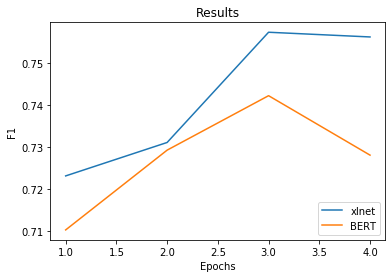

In [0]:
import matplotlib.pyplot as plt
plt.plot(epochs,xlnet,label="xlnet")
plt.plot(epochs,bert,label="BERT")
plt.title("Results")
plt.xlabel('Epochs')
plt.ylabel('F1')
plt.legend(loc='lower right')

In [0]:
[i[('F1 score', 'Micro')] for i in bert_test_scores[0]]

[0.7171792948237059,
 0.7169523809523809,
 0.7161219243481455,
 0.7347966894566391,
 0.7298747763864043,
 0.7230989956958391,
 0.7254464285714286,
 0.7325826882477129,
 0.7365398420674802,
 0.7285869172388869,
 0.7241620111731844,
 0.7236036036036037,
 0.7174982431482784,
 0.7119831814996495,
 0.7296825950470875,
 0.7242120343839542,
 0.7337526205450734,
 0.7218519817607857,
 0.7227066620160446,
 0.7206192821956368,
 0.7168610816542947,
 0.7225534900035075,
 0.7196943383119138,
 0.7215235357527847,
 0.7202275151084252,
 0.7162454873646209,
 0.7229888926287446,
 0.7206823027718551,
 0.732335537765402,
 0.7139294620591379,
 0.7188385269121813,
 0.7258396161754626,
 0.7077785564120533,
 0.7164388363126533,
 0.7007616974972796,
 0.7001834862385321,
 0.7281519861830742,
 0.7032564946944749,
 0.7082607180202162,
 0.717032967032967]